# The Cornell Movie-Dialogs Corpus
Available at [https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html).

> Danescu-Niculescu-Mizil, C., & Lee, L. (2011, June). Chameleons in imagined conversations: A new approach to understanding coordination of linguistic style in dialogs. In Proceedings of the 2nd workshop on cognitive modeling and computational linguistics (pp. 76-87). Association for Computational Linguistics.

The dataset has been uploaded in `MongoDb` using the script available [here](https://github.com/afflint/inforet/blob/master/thematic-studies/language-models/dataset/acquisition.ipynb).

In [5]:
import pymongo

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

In [2]:
db = pymongo.MongoClient()['movie-dialogs']
movies = db['movies']
characters = db['characters']
lines = db['lines']
dialogs = db['conversations']

NameError: name 'pymongo' is not defined

## Movie overview

In [1]:
u = {'$unwind': '$genres'}
g = {'$group': {'_id': '$genres', 
                'movies': {'$sum': 1},
                'avg rating': {'$avg': '$rating'},
                'avg votes': {'$avg': '$votes'},
                'min year': {'$min': '$year'},
                'max year': {'$max': '$year'},
               }}

In [23]:
data, other_count = [], 0
others = {'genre': 'others', 'movies': 0,
          'avg rating': 0, 'avg votes': 0, 'min year': 5000, 
          'max year': 0}
for record in movies.aggregate([u, g]):
    if record['movies'] > 50:
        data.append({'genre': record['_id'], 
                     'movies': record['movies'],
                     'avg rating': record['avg rating'],
                     'avg votes': record['avg votes'],
                     'min year': record['min year'],
                     'max year': record['max year'],
                    })
    else:
        other_count += 1
        others['movies'] += record['movies']
        others['avg rating'] += record['avg rating']
        others['avg votes'] += record['avg votes']
        if record['min year'] < others['min year']:
            others['min year'] = record['min year']
        if record['max year'] > others['max year']:
            others['max year'] = record['max year']
others['avg rating'] = others['avg rating'] / other_count
others['avg votes'] = others['avg votes'] / other_count
data.append(others)
d = pd.DataFrame(data)
d.set_index('genre', inplace=True)

print(d.to_markdown())

print(pd.DataFrame(d.agg({'movies': 'sum', 'avg rating': 'mean', 
        'avg votes': 'mean', 'min year': 'min',
        'max year': 'max'
       })).T.to_markdown())

## Characters overview

In [35]:
print(characters.count_documents({}))
print(characters.count_documents({}) / movies.count_documents({}))
print(characters.count_documents({'gender': 'm'}))
print(characters.count_documents({'gender': 'f'}))

9035
14.643435980551054
1899
921


In [36]:
g = {'$group': {'_id': '$gender', 'count': {'$sum': 1}}}
for r in characters.aggregate([g]):
    print(r)

{'_id': 'F', 'count': 45}
{'_id': 'M', 'count': 150}
{'_id': '?', 'count': 6020}
{'_id': 'm', 'count': 1899}
{'_id': 'f', 'count': 921}


## Lines

In [39]:
lines.count_documents({})

304713

### Distribution by movie

In [45]:
g = {'$group': {'_id': '$character.movie.id', 
     'count': {'$sum': 1}}}
lm = []
for r in lines.aggregate([g]):
    lm.append(r['count'])

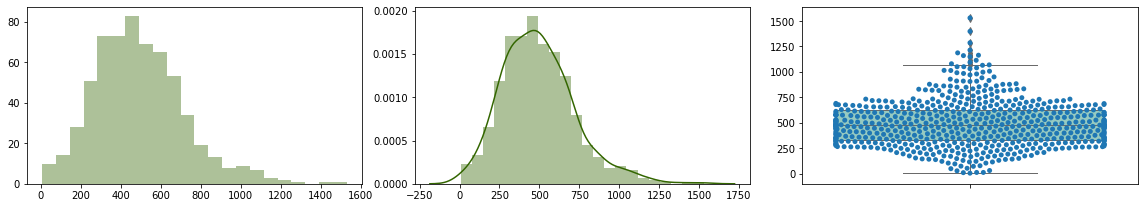

In [76]:
fix, ax = plt.subplots(figsize=(16, 3), ncols=3)
sns.distplot(lm, kde=False, ax=ax[0], color="#336600")
sns.distplot(lm, kde=True, ax=ax[1], color="#336600")
sns.boxplot(y=lm, ax=ax[2], linewidth=1, palette="Set3")
sns.swarmplot(y=lm, ax=ax[2])
plt.tight_layout()
plt.savefig('imgs/moviedist.png')
plt.show()

### Distribution by character

In [77]:
g = {'$group': {'_id': '$character.id', 
     'count': {'$sum': 1}}}
lc = []
for r in lines.aggregate([g]):
    lc.append(r['count'])

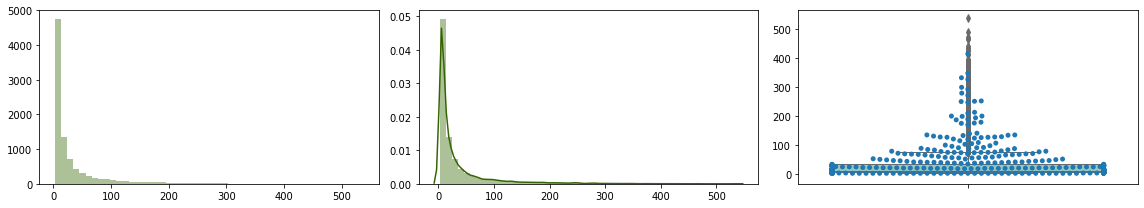

In [81]:
fix, ax = plt.subplots(figsize=(16, 3), ncols=3)
sns.distplot(lc, kde=False, ax=ax[0], color="#336600")
sns.distplot(lc, kde=True, ax=ax[1], color="#336600")
sns.boxplot(y=lc, ax=ax[2], linewidth=1, palette="Set3")
sns.swarmplot(y=lc[:500], ax=ax[2])
plt.tight_layout()
plt.savefig('imgs/chardist.png')
plt.show()

## Conversations

In [84]:
from scipy import stats

In [82]:
convlen = np.array([x['len'] for x in dialogs.find()])

In [86]:
print(stats.describe(convlen))

DescribeResult(nobs=83097, minmax=(2, 89), mean=3.6669554857576085, variance=8.362496306300445, skewness=4.5170900467725215, kurtosis=41.5252425738162)


In [87]:
g = {'$group': {'_id': '$character_a.id', 
     'count': {'$sum': '$len'}}}
cc = []
for r in dialogs.aggregate([g]):
    cc.append(r['count'])

In [88]:
g = {'$group': {'_id': '$movie.id', 
     'count': {'$sum': '$len'}}}
cm = []
for r in dialogs.aggregate([g]):
    cm.append(r['count'])

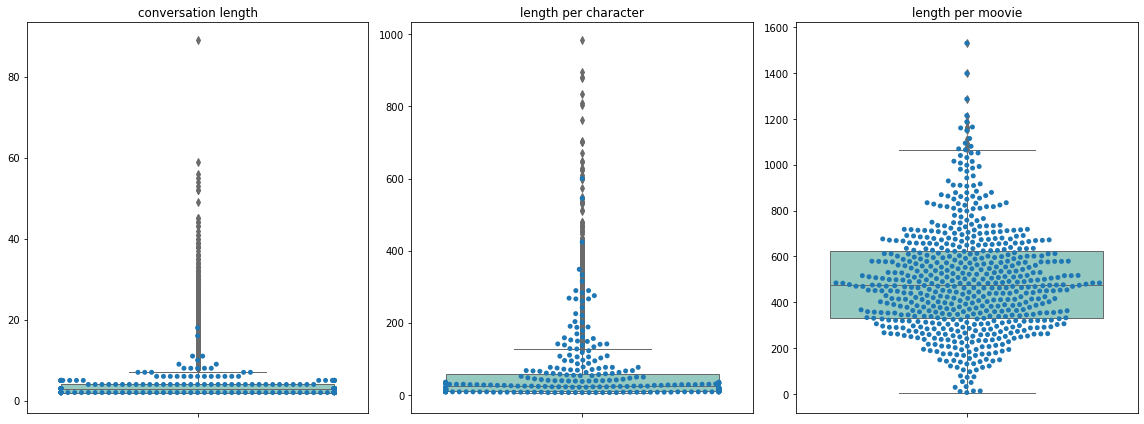

In [94]:
fix, ax = plt.subplots(figsize=(16, 6), ncols=3)
sns.boxplot(y=convlen, ax=ax[0], linewidth=1, palette="Set3")
sns.swarmplot(y=convlen[:300], ax=ax[0])
sns.boxplot(y=cc, ax=ax[1], linewidth=1, palette="Set3")
sns.swarmplot(y=cc[:300], ax=ax[1])
sns.boxplot(y=cm, ax=ax[2], linewidth=1, palette="Set3")
sns.swarmplot(y=cm, ax=ax[2])
ax[0].set_title('conversation length')
ax[1].set_title('length per character')
ax[2].set_title('length per moovie')
plt.tight_layout()
plt.savefig('imgs/convdist.png')
plt.show()